# **Lung-Nodule-Detection: Part-4 Model Optimization**

## 目标

在Part-4部分，应用 **剪枝** 和 **量化** 的模型优化方法，**统计** 优化前后模型的相关参数。具体目标如下：

- 深入理解 **剪枝** 的原理，掌握 ***channel pruning*** 技术（***U-Net*** 的 **跳跃连接** 对剪枝带来的 **复杂度提升**）
- 深入理解 **量化** 的原理，掌握 ***Post-Training Quantization (PTQ)*** 和 ***Quantization-Aware Training (QAT)*** 技术
- 通过统计优化前后的相关参数，直观体会 **模型优化** 带来的 **巨大性能提升**，理解其 **重要性**

## 内容

本节主要由 3 部分组成

- 对 ***U-Net*** 模型进行 **剪枝** 优化，在 ***PC*** 和 ***RK3588S*** 上分别进行部署测试，并统计相关参数。
- 对 ***U-Net*** 模型进行 **量化** 优化，在 ***PC*** 和 ***RK3588S*** 上分别进行部署测试，并统计相关参数。
- 组合 **剪枝 + 量化** 两种优化手段

## 设置
**必须**先执行一次设置代码块

In [1]:
import os
import sys
import torch
import random
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List
%matplotlib inline

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# 获取当前工作目录
current_path = os.getcwd()

# 获取当前目录的最后一个字符串（即最后一个文件夹名）
last_directory = os.path.basename(current_path)

# 检查是否是 notebook
if last_directory == 'notebooks':
    # 切换到上一级目录
    os.chdir('..')

#print(f"切换到目录: {os.getcwd()}")

sys.path.append('src')  # 将模块所在的路径添加到 sys.path

from util.logconf import logging
from util.profile import *
from optimization.pruning import *
from optimization.fx_quantization import *
from app.infer.eval_seg import SegmentationTestingApp
from app.train.training_seg import SegmentationTrainingApp
from deployment.export_onnx import *
from deployment.convert_rknn import *
from core.dsets_seg import TrainingLuna2dSegmentationDataset
from core.model_seg import UNetWrapper

log = logging.getLogger('nb')
Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

2025-06-03 21:49:18.217988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-03 21:49:18.218091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-03 21:49:18.314289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-03 21:49:18.516528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-03 21:49:20.451350: W tensorflow/compiler/tf2

In [2]:
# 设置随机数种子方便复现实验结果
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #torch.set_num_threads(1)

set_random_seed(42)

In [3]:
# 定义一个辅助函数用于启动应用
def run(app, *argv):
    argv = list(argv)
    log.info("Running: {}({!r}).main()".format(app.__name__, argv))
    app(argv).main()
    log.info("Finished: {}.{!r}).main()".format(app.__name__, argv))

In [4]:
def train(model, num_epochs=5):
    arg_epochs = f"--epochs={num_epochs}"
    seg_training_app = SegmentationTrainingApp([arg_epochs, "--num-workers=0", '--augmented', '--finetune'], model)
    return seg_training_app.main()

In [5]:
def evaluate(model, on_rk3588=False, target='rk3588'):
    if on_rk3588:
        assert isinstance(model, str)
        seg_app = SegmentationTestingApp(["--num-workers=0", 
                    "--platform=rknn",
                    f"--model-path={model}",
                    f"--target={target}",
                    "--verbose"], None)
    else:
        assert isinstance(model, nn.Module)
        seg_app = SegmentationTestingApp(["--platform=pytorch", "--num-workers=0"], model)
    return seg_app.eval()

In [6]:
def load_prunned_model(model_path, channel_pruning_ratio):
    model = UNetWrapper(
            in_channels=7,
            n_classes=1,
            depth=3,
            wf=4,
            padding=True,
            batch_norm=True,
            up_mode='upconv',
        )
    sorted_model = apply_channel_sorting_with_skip(model)
    pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
    state_dict = torch.load(model_path, weights_only=True, map_location='cpu')
    pruned_model.load_state_dict(state_dict['model_state'])
    return pruned_model

In [7]:
def eval_perf_mem_on_rk3588(model_path):
    argv = ["--num-workers=0", 
    "--platform=rknn",
    "--model-path={}".format(model_path),
    "--target=rk3588",
    "--perf-debug",
    "--eval-mem",
    "--verbose"]
    #print(argv)
    app = SegmentationTestingApp(argv)
    app.eval_perf_mem()

In [8]:
channel_pruning_ratio = 0.5  # pruned-out ratio

## U-Net 的剪枝 (Pruning) 优化 - Channel Pruning

***Pruning*** 一般分为 ***fine-grained pruning*** 和 ***coarse-grained pruning*** 。

从 ***fine-grained*** 到 ***coarse-grained*** ，伴随着 ***weight*** 的 **压缩率从高到低** ，与此同时，***weight*** 的形状从 **不规则** 逐渐趋向 **规则** ，意味着越来越方便计算。  

***fine-grained pruning*** 虽然可以提供更高的压缩率，但会使得 ***weight*** 变为 **稀疏矩阵** ，稀疏矩阵的加速计算需要 **特殊硬件** 的支持，如 ***NVIDIA*** 的 ***Tensor core*** 支持 **2:4** 的稀疏矩阵。

本实验基于 ***RK3588S*** 的 ***NPU*** 单元，不支持稀疏矩阵的加速，故而采用 ***coarse-grained pruning (channel pruning)***，这种 ***prunning*** 方式适用于一般硬件的加速计算。

![pruning_granularity.png](../images/pruning_granularity.png)

本实验采用的 Prunning 原则为 ***Magnitude-based pruning*** , 即 **绝对值越大的数值被视为越重要** ，保留重要的数值，移除不重要的数值，这样对模型的影响最小。

为了实现上述思想，我们先对权重矩阵的通道进行 **重新排序** ，计算各通道的重要性，然后从高到低依次排序。重排后的模型性能应该与原模型性能几乎完全一致。

In [9]:
print('Before sorting...')
origin_model = load_model()
dense_model_metrics = evaluate(origin_model)
print(dense_model_metrics)

print('After sorting...')
sorted_model = apply_channel_sorting_with_skip(origin_model)
sorted_model_metrics = evaluate(sorted_model)
print(sorted_model_metrics)

# make sure accuracy does not change after sorting, since it is
# equivalent transform
tp_diff = abs(dense_model_metrics['percent_all/tp'] - sorted_model_metrics['percent_all/tp'])
fn_diff = abs(dense_model_metrics['percent_all/fn'] - sorted_model_metrics['percent_all/fn'])
fp_diff = abs(dense_model_metrics['percent_all/fp'] - sorted_model_metrics['percent_all/fp'])
assert tp_diff < 0.1 and fn_diff < 0.1 and fp_diff < 0.1
print('* Check passed.')

#TODO: 输出issues报告，UNet残差连接结构给channel pruning带来的挑战

Before sorting...


eval:   0%|          | 0/71 [00:00<?, ?it/s]

{'loss/all': 0.8396452, 'percent_all/tp': 76.66908502578735, 'percent_all/fn': 23.330913484096527, 'percent_all/fp': 1122.6085662841797, 'pr/precision': 0.06392939, 'pr/recall': 0.76669085, 'pr/f1_score': 0.11801801801801802}
After sorting...


eval:   0%|          | 0/71 [00:00<?, ?it/s]

{'loss/all': 0.83964515, 'percent_all/tp': 76.66908502578735, 'percent_all/fn': 23.330913484096527, 'percent_all/fp': 1122.6080894470215, 'pr/precision': 0.063929416, 'pr/recall': 0.76669085, 'pr/f1_score': 0.11801806336853744}
* Check passed.


实现按 channel 重要性重新排序的功能后，我们开始实现 channel_prune 的函数。根据 channel_purning_ratio ，计算每个通道应该保留的通道数量，删除后面多余的通道。channel_pruning_ratio = 0 时，即没有删除任何通道； channel_pruning_ratio = 1 时，即删除所有通道。

In [10]:
model = load_model()
pruned_model = channel_prune(model, channel_pruning_ratio)

dense_model_size = get_model_size(model)
pruned_model_size = get_model_size(pruned_model)

print(f"dense model has size={dense_model_size/MiB:.2f} MiB")
print(f"pruned model has size={pruned_model_size/MiB:.2f} MiB")

dumpy_input = torch.randn(1,7,512,512).to(device)
dumpuy_output = pruned_model(dumpy_input)

dense model has size=0.45 MiB
pruned model has size=0.12 MiB


结合 ***apply_channel_sorting_with_skip*** 和 ***channel_prune*** 两个函数，即可实现 ***Magnitude-based channel pruning*** 。

In [11]:
print(" * Original model...")
model = load_model()
metrics_dict = evaluate(model)
print(metrics_dict)

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
metrics_dict = evaluate(pruned_model)
print(metrics_dict)

print(" * With sorting...")
sorted_model = apply_channel_sorting_with_skip(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
metrics_dict = evaluate(pruned_model)
print(metrics_dict)

 * Original model...


eval:   0%|          | 0/71 [00:00<?, ?it/s]

{'loss/all': 0.8396452, 'percent_all/tp': 76.66908502578735, 'percent_all/fn': 23.330913484096527, 'percent_all/fp': 1122.6085662841797, 'pr/precision': 0.06392939, 'pr/recall': 0.76669085, 'pr/f1_score': 0.11801801801801802}
 * Without sorting...


eval:   0%|          | 0/71 [00:00<?, ?it/s]

{'loss/all': 0.9951413, 'percent_all/tp': 63.174790143966675, 'percent_all/fn': 36.825209856033325, 'percent_all/fp': 27915.390014648438, 'pr/precision': 0.002257971, 'pr/recall': 0.6317479, 'pr/f1_score': 0.004499859107176718}
 * With sorting...


eval:   0%|          | 0/71 [00:00<?, ?it/s]

{'loss/all': 0.9816362, 'percent_all/tp': 0.1237117568962276, 'percent_all/fn': 99.87629055976868, 'percent_all/fp': 23.119786381721497, 'pr/precision': 0.0053224247, 'pr/recall': 0.0012371176, 'pr/f1_score': 0.00200759893685519}


可以看到，channel_pruning 之后，模型对阳性的预测大幅度下降，更倾向于预测为阴性。尤其是 sorting 之后再 chanenl_purne 的模型，fn = 100%，这说明对阳性的预测隐藏于 **细节（小权重）** 之中，而删除这些小权重之后，模型失去了对阳性的预测能力。

|model|loss|tp|fn|fp|
|-|-|-|-|-|
|original|0.8396|76.7%|23.3%|1122.6%|
|pruned without sorting|0.9951|63.2%|36.8%|27915.4%|
|pruned with sorting|0.9816|0.1%|99.9%|23.1%|

我们期待后续的 **微调** 步骤，可以恢复模型的精度，帮助重新识别细节特征。

In [12]:
num_finetune_epochs = 5
finetuned_pruned_models = train(pruned_model, num_finetune_epochs)

2025-06-01 15:48:35,540 INFO     pid:191535 app.train.training_seg:165:initModel Using CUDA; 1 devices.
2025-06-01 15:48:49,682 INFO     pid:191535 app.train.training_seg:229:main Starting SegmentationTrainingApp, Namespace(batch_size=16, num_workers=0, epochs=5, augmented=True, augment_flip=False, augment_offset=False, augment_scale=False, augment_rotate=False, augment_noise=False, tb_prefix='seg', comment='none', finetune=True)
2025-06-01 15:48:51,117 INFO     pid:191535 core.dsets_seg:283:__init__ <core.dsets_seg.TrainingLuna2dSegmentationDataset object at 0x72de0bb98c10>: 799 training series, 8343 slices, 1028 nodules
2025-06-01 15:48:51,209 INFO     pid:191535 core.dsets_seg:283:__init__ <core.dsets_seg.Luna2dSegmentationDataset object at 0x72deec4ba2b0>: 89 validation series, 1122 slices, 154 nodules
2025-06-01 15:48:51,211 INFO     pid:191535 app.train.training_seg:240:main Epoch 1 of 5, 6250/71 batches of size 16*1
2025-06-01 15:48:51,552 WARNING  pid:191535 util.util:221:enume

对模型进行微调后，可以恢复到原有的精度。一般来说，channel pruning 比 fine-grained pruning 更难以微调来恢复精度。但是，channel pruning 可以在不依赖对稀疏矩阵特殊支持的情况下，在一般的硬件上获得更快的计算。

|model|loss|tp|fn|fp|
|-|-|-|-|-|
|original|0.8396|76.7%|23.3%|1122.6%|
|finetuned, ***epoch-3***|0.9185|78.7%|21.3%|2216.8%|
|finetuned, ***epoch-5***|0.8663|75.3%|24.7%|1292.7%|

我们选择 ***epoch-5*** 为最佳模型，基本维持召回率的同时，并没有使得 fp 的百分比上升太多。

In [13]:
finetuned_pruned_model = load_prunned_model("data/models/seg/seg-prunned-finetuned_2025-06-01_14.40.54_none.500000.state", channel_pruning_ratio)
finetuned_pruned_model = finetuned_pruned_model.to('cuda')
evaluate(finetuned_pruned_model)

eval:   0%|          | 0/71 [00:00<?, ?it/s]

{'loss/all': 0.8662549,
 'percent_all/tp': 75.34506320953369,
 'percent_all/fn': 24.65493679046631,
 'percent_all/fp': 1292.7061080932617,
 'pr/precision': 0.05507474,
 'pr/recall': 0.75345063,
 'pr/f1_score': 0.10264637051546263}

测量 pruning 优化后模型的 ***latency / MACs / params*** 3个参数，并与优化前进行对比。

In [14]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

In [15]:
def show_perf_diff(model, pruned_model):
    table_template = "{:<15} {:<15} {:<15} {:<15}"
    print (table_template.format('', 'Original','Pruned','Reduction Ratio'))
    
    # 1. measure the latency of the original model and the pruned model on GPU
    dummy_input = torch.randn(1, 7, 512, 512).to('cuda')
    pruned_model = pruned_model.to('cuda')
    model = model.to('cuda')
    
    pruned_latency = measure_latency(pruned_model, dummy_input)
    original_latency = measure_latency(model, dummy_input)
    print(table_template.format('Latency (ms)',
                                round(original_latency * 1000, 1),
                                round(pruned_latency * 1000, 1),
                                round(original_latency / pruned_latency, 1)))
    
    # 2. measure the computation (MACs)
    original_macs = get_model_macs(model, dummy_input)
    pruned_macs = get_model_macs(pruned_model, dummy_input)
    print(table_template.format('MACs (M)',
                                round(original_macs / 1e6),
                                round(pruned_macs / 1e6),
                                round(original_macs / pruned_macs, 1)))
    
    # 3. measure the model size (params)
    original_param = get_num_parameters(model)
    pruned_param = get_num_parameters(pruned_model)
    print(table_template.format('Param (M)',
                                round(original_param / 1e6, 2),
                                round(pruned_param / 1e6, 2),
                                round(original_param / pruned_param, 1)))

In [16]:
show_perf_diff(load_model(), finetuned_pruned_model)

                Original        Pruned          Reduction Ratio
Latency (ms)    21.2            16.2            1.3            
MACs (M)        7413            2084            3.6            
Param (M)       0.12            0.03            3.9            


实际部署到 RK3588S-NPU 上运行，统计优化前后的 ***latency / memory(weight memory)*** 参数

In [17]:
# original model perf on NPU

# 导出分割模型为ONNX格式
export_onnx(["--import-path=data/models/seg/seg_2025-04-30_18.55.29_seg.3500000.state", 
             "--export-path=optimization/models",
            "--input-shape", "1", "7", "512", "512", "--model-type=seg"])

# 将 ONNX 转换成 RKNN
convert_main(["--import-path=optimization/models/seg_model.onnx", "--export-path=optimization/models", "--model-type=seg", "--platform=rk3588"])

# 评估性能和内存
eval_perf_mem_on_rk3588("optimization/models/seg_model.rknn")

# 评估召回率，这一项在 3_model_deploy.ipynb 中已经做过
# evaluate("optimization/models/seg_model.rknn", on_rk3588=True)

export to optimization/models/seg_model.onnx


I rknn-toolkit2 version: 2.3.2


--> Config model
is model pruning enabled:  False
done
--> Loading model


I Loading : 100%|█████████████████████████████████████████████████| 70/70 [00:00<00:00, 7552.44it/s]
W load_onnx: The config.mean_values is None, zeros will be set for input 0!
W load_onnx: The config.std_values is None, ones will be set for input 0!
W build: The dataset='./calib_data/dataset.txt' is ignored because do_quantization = False!


done
--> Building model


I OpFusing 2 : 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 798.43it/s]

I OpFusing 2 : 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 188.85it/s]
I rknn building ...
I rknn building done.
I rknn-toolkit2 version: 2.3.2


done
--> Export rknn model
done


I target set by user is: rk3588
adb: unable to connect for root: closed


--> Init runtime environment


I Get hardware info: target_platform = rk3588, os = Linux, aarch = aarch64
I Check RK3588 board npu runtime version
I Starting ntp or adb, target is RK3588
I Start adb...
I Connect to Device success!
I Flag perf_debug has been set, it will affect the performance of inference!
I Flag eval_mem has been set, it will affect the performance of inference!


I NPUTransfer(191535): Starting NPU Transfer Client, Transfer version 2.2.2 (12abf2a@2024-09-02T03:22:41)
I NPUTransfer(191535): TransferBuffer: min aligned size: 1024
D RKNNAPI: ==============================================
D RKNNAPI: RKNN VERSION:
D RKNNAPI:   API: 2.3.2 (1842325 build@2025-03-30T09:55:23)
D RKNNAPI:   DRV: rknn_server: 2.3.2 (1842325 build@2025-03-30T09:54:34)
D RKNNAPI:   DRV: rknnrt: 2.3.2 (429f97ae6b@2025-04-09T09:09:27)
D RKNNAPI: ==============================================
D RKNNAPI: Input tensors:
done
Model-optimization/models/seg_model.rknn is rknn model, starting val
--> Eval perf
D RKNNAPI:   index=0, name=input, n_dims=4, dims=[1, 512, 512, 7], n_elems=1835008, size=3670016, w_stride = 0, size_with_stride = 0, fmt=NHWC, type=FP16, qnt_type=NONE, zp=0, scale=1.000000
D RKNNAPI: Output tensors:
D RKNNAPI:   index=0, name=output, n_dims=4, dims=[1, 1, 512, 512], n_elems=262144, size=524288, w_stride = 0, size_with_stride = 0, fmt=NCHW, type=FP16, qnt_typ

In [18]:
# auto-pruned model perf on NPU 

# 导出分割模型为ONNX格式
export_onnx(["--import-path=data/models/seg/seg_2025-04-30_18.55.29_seg.3500000.state", 
             "--export-path=optimization/models",
            "--input-shape", "1", "7", "512", "512", "--model-type=seg"])

# 将 ONNX 转换成 RKNN
convert_main(["--import-path=optimization/models/seg_model.onnx", "--export-path=optimization/models", "--model-type=seg", "--platform=rk3588", 
             "--pruning"])

# 因为原模型的稀疏化程度不够，实际SDK自带的 pruning 算法根本没有运行，所以这里不再调用 eval_perf_mem_on_rk3588
#eval_perf_mem_on_rk3588("optimization/models/seg_model.rknn")

I rknn-toolkit2 version: 2.3.2


export to optimization/models/seg_model.onnx
--> Config model
is model pruning enabled:  True
done
--> Loading model


I Loading : 100%|████████████████████████████████████████████████| 70/70 [00:00<00:00, 80504.88it/s]
W load_onnx: The config.mean_values is None, zeros will be set for input 0!
W load_onnx: The config.std_values is None, ones will be set for input 0!
W build: The dataset='./calib_data/dataset.txt' is ignored because do_quantization = False!


done
--> Building model


I OpFusing 2 : 100%|████████████████████████████████████████████| 100/100 [00:00<00:00, 2032.80it/s]

I OpFusing 2 : 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 218.39it/s]
I rknn building ...
I rknn building done.


done
--> Export rknn model
done


In [19]:
# self-pruned model perf on NPU

# 导出模型为ONNX格式
finetuned_pruned_model.to("cpu")
export_onnx(["--export-path=optimization/models",
             "--input-shape", "1", "7", "512", "512", "--model-type=seg"],
             finetuned_pruned_model)
finetuned_pruned_model = finetuned_pruned_model.to("cuda")

# 将 ONNX 转换成 RKNN
convert_main(["--import-path=optimization/models/seg_model.onnx", 
              "--export-path=optimization/models", "--model-type=seg", "--platform=rk3588"])

# 评估性能和内存
eval_perf_mem_on_rk3588("optimization/models/seg_model.rknn")

I rknn-toolkit2 version: 2.3.2


export to optimization/models/seg_model.onnx
--> Config model
is model pruning enabled:  False
done
--> Loading model


I Loading : 100%|███████████████████████████████████████████████| 70/70 [00:00<00:00, 114108.54it/s]
W load_onnx: The config.mean_values is None, zeros will be set for input 0!
W load_onnx: The config.std_values is None, ones will be set for input 0!
W build: The dataset='./calib_data/dataset.txt' is ignored because do_quantization = False!


done
--> Building model


I OpFusing 2 : 100%|████████████████████████████████████████████| 100/100 [00:00<00:00, 1949.72it/s]

I OpFusing 2 : 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 379.78it/s]
I rknn building ...
I rknn building done.
I rknn-toolkit2 version: 2.3.2
adb: unable to connect for root: closed
I target set by user is: rk3588


done
--> Export rknn model
done
--> Init runtime environment


I Get hardware info: target_platform = rk3588, os = Linux, aarch = aarch64
I Check RK3588 board npu runtime version
I Starting ntp or adb, target is RK3588
I Start adb...
I Connect to Device success!
I Flag perf_debug has been set, it will affect the performance of inference!
I Flag eval_mem has been set, it will affect the performance of inference!


I NPUTransfer(191535): Starting NPU Transfer Client, Transfer version 2.2.2 (12abf2a@2024-09-02T03:22:41)
I NPUTransfer(191535): TransferBuffer: min aligned size: 1024
D RKNNAPI: ==============================================
D RKNNAPI: RKNN VERSION:
D RKNNAPI:   API: 2.3.2 (1842325 build@2025-03-30T09:55:23)
D RKNNAPI:   DRV: rknn_server: 2.3.2 (1842325 build@2025-03-30T09:54:34)
D RKNNAPI:   DRV: rknnrt: 2.3.2 (429f97ae6b@2025-04-09T09:09:27)
D RKNNAPI: ==============================================
D RKNNAPI: Input tensors:
done
Model-optimization/models/seg_model.rknn is rknn model, starting val
--> Eval perf
D RKNNAPI:   index=0, name=input, n_dims=4, dims=[1, 512, 512, 7], n_elems=1835008, size=3670016, w_stride = 0, size_with_stride = 0, fmt=NHWC, type=FP16, qnt_type=NONE, zp=0, scale=1.000000
D RKNNAPI: Output tensors:
D RKNNAPI:   index=0, name=output, n_dims=4, dims=[1, 1, 512, 512], n_elems=262144, size=524288, w_stride = 0, size_with_stride = 0, fmt=NCHW, type=FP16, qnt_typ

In [20]:
# 评估召回率
evaluate("optimization/models/seg_model.rknn", on_rk3588=True)

I rknn-toolkit2 version: 2.3.2


--> Init runtime environment


adb: unable to connect for root: closed
I target set by user is: rk3588
I Get hardware info: target_platform = rk3588, os = Linux, aarch = aarch64
I Check RK3588 board npu runtime version
I Starting ntp or adb, target is RK3588
I Start adb...
I Connect to Device success!


I NPUTransfer(191535): Starting NPU Transfer Client, Transfer version 2.2.2 (12abf2a@2024-09-02T03:22:41)
I NPUTransfer(191535): TransferBuffer: min aligned size: 1024
D RKNNAPI: ==============================================
D RKNNAPI: RKNN VERSION:
D RKNNAPI:   API: 2.3.2 (1842325 build@2025-03-30T09:55:23)
D RKNNAPI:   DRV: rknn_server: 2.3.2 (1842325 build@2025-03-30T09:54:34)
D RKNNAPI:   DRV: rknnrt: 2.3.2 (429f97ae6b@2025-04-09T09:09:27)
D RKNNAPI: ==============================================
D RKNNAPI: Input tensors:
done
Model-optimization/models/seg_model.rknn is rknn model, starting val
D RKNNAPI:   index=0, name=input, n_dims=4, dims=[1, 512, 512, 7], n_elems=1835008, size=3670016, w_stride = 0, size_with_stride = 0, fmt=NHWC, type=FP16, qnt_type=NONE, zp=0, scale=1.000000
D RKNNAPI: Output tensors:
D RKNNAPI:   index=0, name=output, n_dims=4, dims=[1, 1, 512, 512], n_elems=262144, size=524288, w_stride = 0, size_with_stride = 0, fmt=NCHW, type=FP16, qnt_type=NONE, zp=0, 

2025-06-01 16:05:57,818 INFO     pid:191535 app.infer.eval_seg:209:eval 1122 batches of size 1*1


eval:   0%|          | 0/1122 [00:00<?, ?it/s]

2025-06-01 16:22:25,152 INFO     pid:191535 app.infer.eval_seg:308:logMetrics E0 SegmentationTestingApp
2025-06-01 16:22:25,171 INFO     pid:191535 app.infer.eval_seg:338:logMetrics E0 val      0.9068 loss, 0.0552 precision, 0.7532 recall, 0.1029 f1 score
2025-06-01 16:22:25,172 INFO     pid:191535 app.infer.eval_seg:348:logMetrics E0 val_all  0.9068 loss,  75.3% tp,  24.7% fn,    1288.3% fp


{'loss/all': 0.9067731,
 'percent_all/tp': 75.31746029853821,
 'percent_all/fn': 24.68254119157791,
 'percent_all/fp': 1288.2683753967285,
 'pr/precision': 0.05523485,
 'pr/recall': 0.7531746,
 'pr/f1_score': 0.10292182106133957}

对比一下剪枝前后，部署在 NPU 上运行的关键指标

||original|pruned|reduction ratio|accuracy drop|
|-|-|-|-|-|
|recall|76.7%|75.3%|/|-1.4%|
|model size (KiB)|1005.18|514.05|1.96x|/|
|latency (us)|49079|30171|1.63x|/|

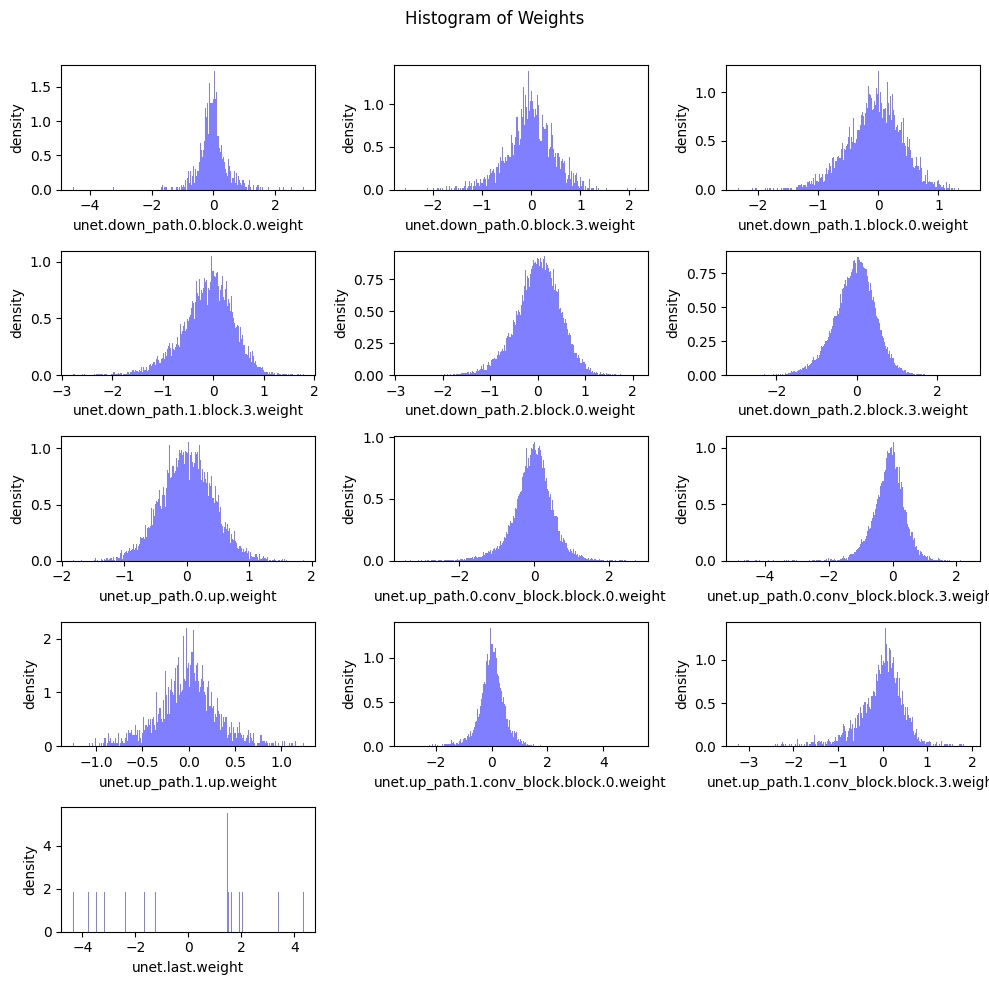

In [18]:
#plot_weight_distribution(model)

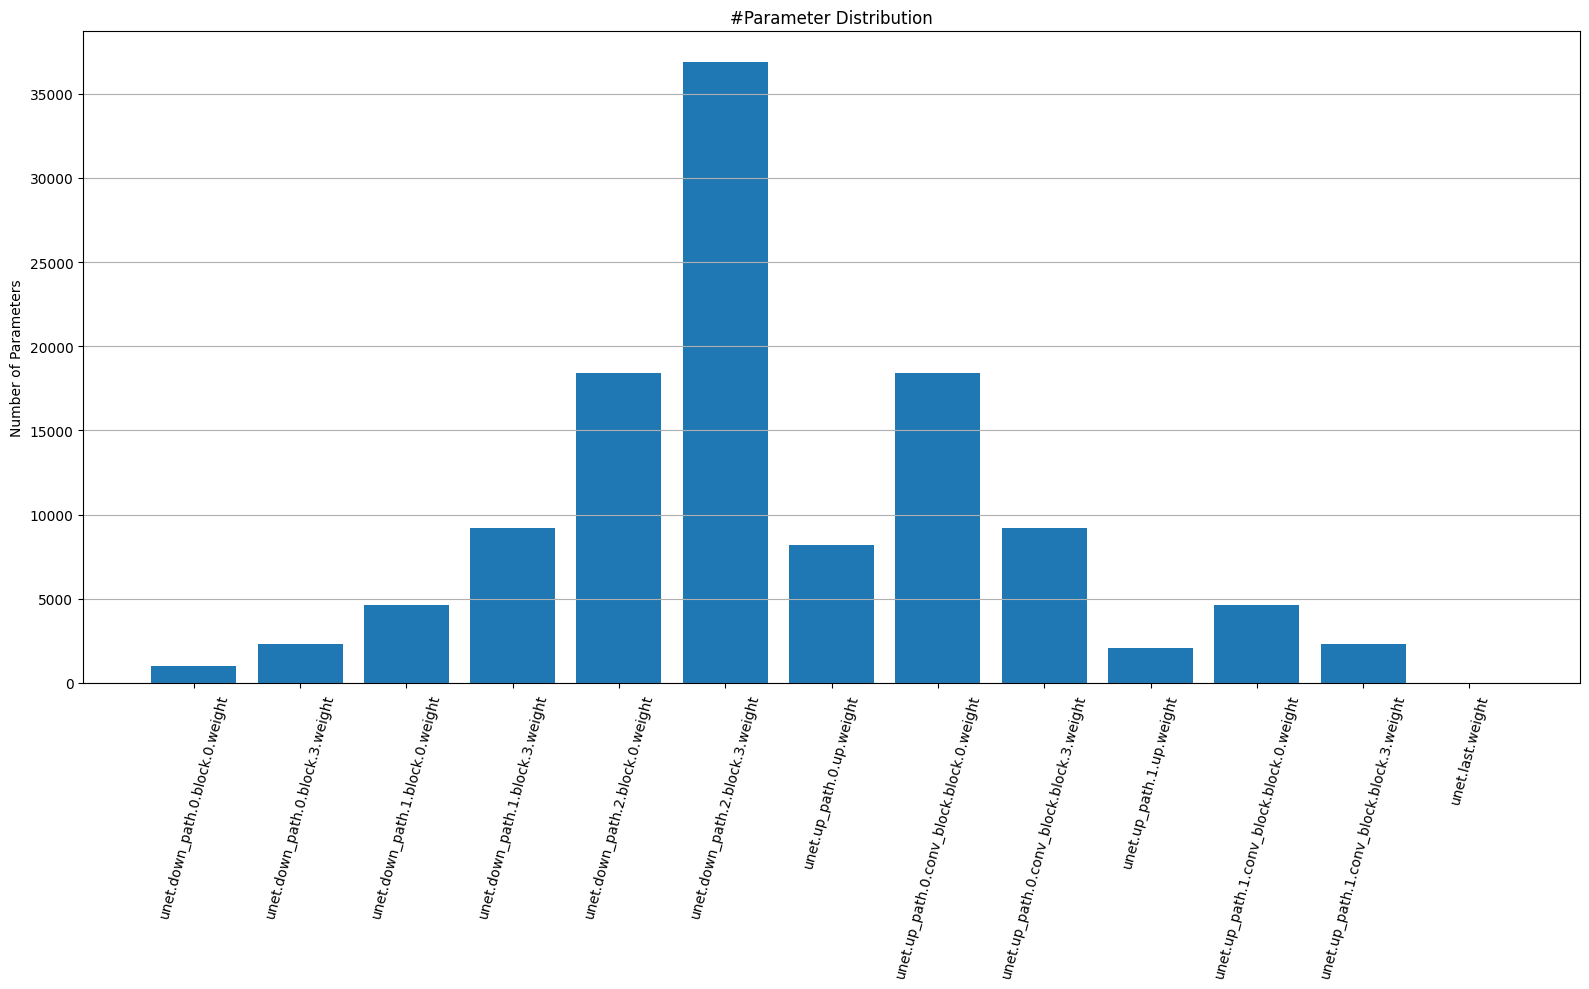

In [19]:
#plot_num_parameters_distribution(model)

## U-Net 的量化(Quantization) - Int8

Quantization 有 2 种类别：
- K-Means-based Quantization
- Linear Quantization

K-Means-based Quantization 一般更易保持模型精度，但不利于硬件加速。通常在 4bit 下仍可保持一定精度，超过 4bit 精度损失过大，有 8x 的压缩率。（全连接层通常在 2bit 下仍可保持精度）。

Linear Quantization 通过使用 Int8 量化，有利于硬件加速，便于部署。由于精度损失，通常配合 QAT 技术恢复模型精度。

本实验需要部署到 RK3588S 开发板上，选择使用 Linear + QAT 的方案。

RKNN-Toolkit2 (Rockchip 配套的模型调优工具) 支持 Int8 量化，并提供如下 3 种量化算法：
- Normal量化算法运行速度快，适用于一般场景。
- KL-Divergence量化算法运行速度略慢于Normal量化算法，对于存在非均匀分布的部分模型能够改善量化
精度，部分场景下能够缓解少数异常值造成的量化精度丢失问题。
- MMSE量化算法运行速度较慢，内存消耗大，相比KL_Divergence量化算法能够更好的缓解异常值造成的
量化精度丢失问题。对于量化友好的模型可尝试使用MMSE量化算法来提高量化精度，因为在多数场景
下MMSE量化精度要高于Normal和KL-Divergence量化算法。

本实验选择 Int8 + Normal 的量化方案，先看看效果。

首先，我们需要从训练集里挑选出 **量化校正集**，量化校正集中结节直径大小的分布，应该与训练集中的结界直径大小分布相同。

In [21]:
# 创建量化校正集
train_ds = TrainingLuna2dSegmentationDataset(
            val_stride=10,
            isValSet_bool=False,
            contextSlices_count=3,
            save_calib=True,
            calib_count=100,
            calib_dir='./calib_data'
        )

2025-06-01 16:30:45,387 INFO     pid:191535 core.dsets_seg:283:__init__ <core.dsets_seg.TrainingLuna2dSegmentationDataset object at 0x72de0dd8ccd0>: 799 training series, 8343 slices, 1028 nodules


calib-data:   0%|          | 0/103 [00:00<?, ?it/s]

2025-06-01 16:32:12,214 INFO     pid:191535 core.dsets_seg:380:save_calibration_set Save calibration dataset completed.


有了量化校正集之后，我们设置好量化数据类型(Int8)+量化算法(Normal)，对原始模型进行量化并导出为 RKNN 模型

In [22]:
# 导出分割模型为ONNX格式
export_onnx(["--import-path=data/models/seg/seg_2025-04-30_18.55.29_seg.3500000.state", 
             "--export-path=optimization/models",
            "--input-shape", "1", "7", "512", "512", "--model-type=seg"])

# 将 ONNX 转换成 RKNN，同时启用 INT8 + Normal 量化
convert_main(["--import-path=optimization/models/seg_model.onnx",
              "--export-path=optimization/models",
              "--model-type=seg",
              "--platform=rk3588",
              "--dtype=i8",
              "--quantized-algorithm=normal"
              #"--accuracy-analysis"
             ])

I rknn-toolkit2 version: 2.3.2


export to optimization/models/seg_model.onnx
--> Config model
is model pruning enabled:  False
done
--> Loading model


I Loading : 100%|████████████████████████████████████████████████| 70/70 [00:00<00:00, 23383.35it/s]
W load_onnx: The config.mean_values is None, zeros will be set for input 0!
W load_onnx: The config.std_values is None, ones will be set for input 0!


done
--> Building model


I OpFusing 2 : 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 962.55it/s]

I Quantizating 7/7: 100%|███████████████████████████████████████████| 38/38 [00:03<00:00, 10.54it/s]
W build: The default input dtype of 'input' is changed from 'float32' to 'int8' in rknn model for performance!
                       Please take care of this change when deploy rknn model with Runtime API!
W build: The default output dtype of 'output' is changed from 'float32' to 'int8' in rknn model for performance!
                      Please take care of this change when deploy rknn model with Runtime API!
I rknn building ...
I rknn building done.


done
--> Export rknn model
done


In [23]:
# 评估性能和内存
eval_perf_mem_on_rk3588("optimization/models/seg_model.rknn")

I rknn-toolkit2 version: 2.3.2
adb: unable to connect for root: closed
I target set by user is: rk3588


--> Init runtime environment


I Get hardware info: target_platform = rk3588, os = Linux, aarch = aarch64
I Check RK3588 board npu runtime version
I Starting ntp or adb, target is RK3588
I Start adb...
I Connect to Device success!
I Flag perf_debug has been set, it will affect the performance of inference!
I Flag eval_mem has been set, it will affect the performance of inference!


I NPUTransfer(191535): Starting NPU Transfer Client, Transfer version 2.2.2 (12abf2a@2024-09-02T03:22:41)
I NPUTransfer(191535): TransferBuffer: min aligned size: 1024
D RKNNAPI: ==============================================
D RKNNAPI: RKNN VERSION:
D RKNNAPI:   API: 2.3.2 (1842325 build@2025-03-30T09:55:23)
D RKNNAPI:   DRV: rknn_server: 2.3.2 (1842325 build@2025-03-30T09:54:34)
D RKNNAPI:   DRV: rknnrt: 2.3.2 (429f97ae6b@2025-04-09T09:09:27)
D RKNNAPI: ==============================================
D RKNNAPI: Input tensors:
D RKNNAPI:   index=0, name=input, n_dims=4, dims=[1, 512, 512, 7], n_elems=1835008, size=1835008, w_stride = 0, size_with_stride = 0, fmt=NHWC, type=INT8, qnt_type=AFFINE, zp=0, scale=7.843137
D RKNNAPI: Output tensors:
D RKNNAPI:   index=0, name=output, n_dims=4, dims=[1, 1, 512, 512], n_elems=262144, size=262144, w_stride = 0, size_with_stride = 0, fmt=NCHW, type=INT8, qnt_type=AFFINE, zp=-128, scale=0.003922
done
Model-optimization/models/seg_model.rknn is rkn

In [24]:
# 评估召回率
evaluate("optimization/models/seg_model.rknn", on_rk3588=True)

I rknn-toolkit2 version: 2.3.2


--> Init runtime environment


adb: unable to connect for root: closed
I target set by user is: rk3588
I Get hardware info: target_platform = rk3588, os = Linux, aarch = aarch64
I Check RK3588 board npu runtime version
I Starting ntp or adb, target is RK3588
I Start adb...
I Connect to Device success!


I NPUTransfer(191535): Starting NPU Transfer Client, Transfer version 2.2.2 (12abf2a@2024-09-02T03:22:41)
I NPUTransfer(191535): TransferBuffer: min aligned size: 1024
D RKNNAPI: ==============================================
D RKNNAPI: RKNN VERSION:
D RKNNAPI:   API: 2.3.2 (1842325 build@2025-03-30T09:55:23)
D RKNNAPI:   DRV: rknn_server: 2.3.2 (1842325 build@2025-03-30T09:54:34)
D RKNNAPI:   DRV: rknnrt: 2.3.2 (429f97ae6b@2025-04-09T09:09:27)
D RKNNAPI: ==============================================


2025-06-01 16:33:19,115 INFO     pid:191535 app.infer.eval_seg:209:eval 1122 batches of size 1*1


D RKNNAPI: Input tensors:
done
Model-optimization/models/seg_model.rknn is rknn model, starting val
D RKNNAPI:   index=0, name=input, n_dims=4, dims=[1, 512, 512, 7], n_elems=1835008, size=1835008, w_stride = 0, size_with_stride = 0, fmt=NHWC, type=INT8, qnt_type=AFFINE, zp=0, scale=7.843137
D RKNNAPI: Output tensors:
D RKNNAPI:   index=0, name=output, n_dims=4, dims=[1, 1, 512, 512], n_elems=262144, size=262144, w_stride = 0, size_with_stride = 0, fmt=NCHW, type=INT8, qnt_type=AFFINE, zp=-128, scale=0.003922


eval:   0%|          | 0/1122 [00:00<?, ?it/s]

2025-06-01 16:49:04,209 INFO     pid:191535 app.infer.eval_seg:308:logMetrics E0 SegmentationTestingApp
2025-06-01 16:49:04,210 INFO     pid:191535 app.infer.eval_seg:338:logMetrics E0 val      0.9072 loss, 0.0383 precision, 0.7957 recall, 0.0730 f1 score
2025-06-01 16:49:04,211 INFO     pid:191535 app.infer.eval_seg:348:logMetrics E0 val_all  0.9072 loss,  79.6% tp,  20.4% fn,    2000.2% fp


{'loss/all': 0.90717745,
 'percent_all/tp': 79.57273721694946,
 'percent_all/fn': 20.427265763282776,
 'percent_all/fp': 2000.1733779907227,
 'pr/precision': 0.038260795,
 'pr/recall': 0.7957274,
 'pr/f1_score': 0.07301101522298456}

对比一下量化前后，部署在 NPU 上运行的关键指标

||original|quantized (int8)|reduction ratio|accuracy drop|
|-|-|-|-|-|
|recall|76.7%|79.6%|/|+2.9%|
|model size (KiB)|1005.18|561.83|1.79x|/|
|latency (us)|49079|31536|1.56x|/|

## U-Net 的剪枝+量化

原模型剪枝（50%）之后，微调可以恢复原有精度。原模型量化之后，也可以维持原有精度。

在上述实验背景下，我们尝试结合剪枝和量化两种优化方法，看一下效果。

In [9]:
# 创建量化校正集
train_ds = TrainingLuna2dSegmentationDataset(
            val_stride=10,
            isValSet_bool=False,
            contextSlices_count=3,
            save_calib=True,
            calib_count=100,
            calib_dir='./calib_data'
        )

2025-06-03 21:49:34,751 INFO     pid:1936418 core.dsets_seg:283:__init__ <core.dsets_seg.TrainingLuna2dSegmentationDataset object at 0x7cb7d47147c0>: 799 training series, 8343 slices, 1028 nodules


calib-data:   0%|          | 0/103 [00:00<?, ?it/s]

2025-06-03 21:50:36,873 INFO     pid:1936418 core.dsets_seg:396:save_calibration_set Save calibration dataset completed.


In [10]:
# 导入剪枝后的模型
pruned_model = load_prunned_model("data/models/seg/seg-prunned-finetuned_2025-06-01_14.40.54_none.500000.state", channel_pruning_ratio)
pruned_model = pruned_model.to('cuda')

In [11]:
# 导出模型为ONNX格式
pruned_model.to("cpu")
export_onnx(["--export-path=optimization/models",
             "--input-shape", "1", "7", "512", "512", "--model-type=seg"],
             pruned_model)
pruned_model = pruned_model.to("cuda")

# 将 ONNX 转换成 RKNN，同时启用 INT8 + Normal 量化
convert_main(["--import-path=optimization/models/seg_model.onnx",
              "--export-path=optimization/models",
              "--model-type=seg",
              "--platform=rk3588",
              "--dtype=i8",
              "--quantized-algorithm=normal"
              #"--accuracy-analysis"
             ])

export to optimization/models/seg_model.onnx


I rknn-toolkit2 version: 2.3.2


--> Config model
is model pruning enabled:  False
done
--> Loading model


I Loading : 100%|███████████████████████████████████████████████| 70/70 [00:00<00:00, 154364.50it/s]
W load_onnx: The config.mean_values is None, zeros will be set for input 0!
W load_onnx: The config.std_values is None, ones will be set for input 0!


done
--> Building model


I OpFusing 2 : 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 397.91it/s]


I Quantizating 4/4: 100%|███████████████████████████████████████████| 38/38 [00:01<00:00, 27.45it/s]
W build: The default input dtype of 'input' is changed from 'float32' to 'int8' in rknn model for performance!
                       Please take care of this change when deploy rknn model with Runtime API!
W build: The default output dtype of 'output' is changed from 'float32' to 'int8' in rknn model for performance!
                      Please take care of this change when deploy rknn model with Runtime API!
I rknn building ...
I rknn building done.


done
--> Export rknn model
done


In [12]:
# 评估性能和内存
eval_perf_mem_on_rk3588("optimization/models/seg_model.rknn")

I rknn-toolkit2 version: 2.3.2
adb: unable to connect for root: closed
I target set by user is: rk3588


--> Init runtime environment


I Get hardware info: target_platform = rk3588, os = Linux, aarch = aarch64
I Check RK3588 board npu runtime version
I Starting ntp or adb, target is RK3588
I Start adb...
I Connect to Device success!
I Flag perf_debug has been set, it will affect the performance of inference!
I Flag eval_mem has been set, it will affect the performance of inference!


I NPUTransfer(1936418): Starting NPU Transfer Client, Transfer version 2.2.2 (12abf2a@2024-09-02T03:22:41)
I NPUTransfer(1936418): TransferBuffer: min aligned size: 1024
D RKNNAPI: ==============================================
D RKNNAPI: RKNN VERSION:
D RKNNAPI:   API: 2.3.2 (1842325 build@2025-03-30T09:55:23)
D RKNNAPI:   DRV: rknn_server: 2.3.2 (1842325 build@2025-03-30T09:54:34)
D RKNNAPI:   DRV: rknnrt: 2.3.2 (429f97ae6b@2025-04-09T09:09:27)
D RKNNAPI: ==============================================
D RKNNAPI: Input tensors:
D RKNNAPI:   index=0, name=input, n_dims=4, dims=[1, 512, 512, 7], n_elems=1835008, size=1835008, w_stride = 0, size_with_stride = 0, fmt=NHWC, type=INT8, qnt_type=AFFINE, zp=0, scale=7.843137
D RKNNAPI: Output tensors:
D RKNNAPI:   index=0, name=output, n_dims=4, dims=[1, 1, 512, 512], n_elems=262144, size=262144, w_stride = 0, size_with_stride = 0, fmt=NCHW, type=INT8, qnt_type=AFFINE, zp=-128, scale=0.003922
done
Model-optimization/models/seg_model.rknn is r

In [13]:
# 评估召回率
evaluate("optimization/models/seg_model.rknn", on_rk3588=True)

I rknn-toolkit2 version: 2.3.2
adb: unable to connect for root: closed
I target set by user is: rk3588


--> Init runtime environment


I Get hardware info: target_platform = rk3588, os = Linux, aarch = aarch64
I Check RK3588 board npu runtime version
I Starting ntp or adb, target is RK3588
I Start adb...
I Connect to Device success!


I NPUTransfer(1936418): Starting NPU Transfer Client, Transfer version 2.2.2 (12abf2a@2024-09-02T03:22:41)
I NPUTransfer(1936418): TransferBuffer: min aligned size: 1024
D RKNNAPI: ==============================================
D RKNNAPI: RKNN VERSION:
D RKNNAPI:   API: 2.3.2 (1842325 build@2025-03-30T09:55:23)
D RKNNAPI:   DRV: rknn_server: 2.3.2 (1842325 build@2025-03-30T09:54:34)
D RKNNAPI:   DRV: rknnrt: 2.3.2 (429f97ae6b@2025-04-09T09:09:27)
D RKNNAPI: ==============================================
D RKNNAPI: Input tensors:
done
Model-optimization/models/seg_model.rknn is rknn model, starting val
D RKNNAPI:   index=0, name=input, n_dims=4, dims=[1, 512, 512, 7], n_elems=1835008, size=1835008, w_stride = 0, size_with_stride = 0, fmt=NHWC, type=INT8, qnt_type=AFFINE, zp=0, scale=7.843137
D RKNNAPI: Output tensors:
D RKNNAPI:   index=0, name=output, n_dims=4, dims=[1, 1, 512, 512], n_elems=262144, size=262144, w_stride = 0, size_with_stride = 0, fmt=NCHW, type=INT8, qnt_type=AFFINE, 

2025-06-03 21:51:13,929 INFO     pid:1936418 app.infer.eval_seg:220:eval 1122 batches of size 1*1


eval:   0%|          | 0/1122 [00:00<?, ?it/s]

2025-06-03 22:07:15,276 INFO     pid:1936418 app.infer.eval_seg:319:logMetrics E0 SegmentationTestingApp
2025-06-03 22:07:15,277 INFO     pid:1936418 app.infer.eval_seg:349:logMetrics E0 val      0.8190 loss, 0.0804 precision, 0.6952 recall, 0.1442 f1 score
2025-06-03 22:07:15,278 INFO     pid:1936418 app.infer.eval_seg:359:logMetrics E0 val_all  0.8190 loss,  69.5% tp,  30.5% fn,     794.6% fp


{'loss/all': 0.8190462,
 'percent_all/tp': 69.51629519462585,
 'percent_all/fn': 30.483701825141907,
 'percent_all/fp': 794.5812225341797,
 'pr/precision': 0.080449596,
 'pr/recall': 0.69516295,
 'pr/f1_score': 0.14421009329482404}

可以看到，单独剪枝(微调后)或者量化之后的模型的精度保持得很好，但是**剪枝+量化之后，模型精度下降得厉害**。

主要是因为剪枝之后的模型，尽管已经微调恢复了精度，但相比原始模型，缺少冗余，更易受量化误差影响。

||original|pruned|quantization|pruned + quantization|
|-|-|-|-|-|
|recall|76.7%|75.3%|79.6%|69.5%|
|accuracy drop|/|**-1.4%**|**+2.9%**|**-7.2%**|
|model size (KiB)|1005.18|514.05|561.83|453.83|
|reduction ratio|/|**1.96x**|**1.79x**|**2.21x**|
|latency (us)|49079|30171|31536|29710|
|reduction ratio|/|**1.63x**|**1.56x**|**1.65x**|

我们采用 **QAT** 来提供精度。（经实测，将量化算法改为 **MMSE** 之后，也可以提高精度，但是 QAT 的效果更好。）

In [14]:
# 导入剪枝后的模型
pruned_model = load_prunned_model("data/models/seg/seg-prunned-finetuned_2025-06-01_14.40.54_none.500000.state", channel_pruning_ratio)
pruned_model = pruned_model.to('cuda')
# FX Mode 下的 QAT，将模型转为等待 QAT 
model_qat = prepare_model_qat_fx(pruned_model)

In [15]:
# QAT 微调模型
model_qat = model_qat.to('cuda')
finetuned_qat_models = train(model_qat, 5)

2025-06-03 22:07:16,103 INFO     pid:1936418 app.train.training_seg:165:initModel Using CUDA; 1 devices.
2025-06-03 22:07:17,322 INFO     pid:1936418 app.train.training_seg:229:main Starting SegmentationTrainingApp, Namespace(batch_size=16, num_workers=0, epochs=5, augmented=True, augment_flip=False, augment_offset=False, augment_scale=False, augment_rotate=False, augment_noise=False, tb_prefix='seg', comment='none', finetune=True)
2025-06-03 22:07:18,513 INFO     pid:1936418 core.dsets_seg:283:__init__ <core.dsets_seg.TrainingLuna2dSegmentationDataset object at 0x7cb6ff051d90>: 799 training series, 8343 slices, 1028 nodules
2025-06-03 22:07:18,647 INFO     pid:1936418 core.dsets_seg:283:__init__ <core.dsets_seg.Luna2dSegmentationDataset object at 0x7cb6a47ecac0>: 89 validation series, 1122 slices, 154 nodules
2025-06-03 22:07:18,648 INFO     pid:1936418 app.train.training_seg:240:main Epoch 1 of 5, 6250/71 batches of size 16*1
2025-06-03 22:07:18,883 WARNING  pid:1936418 util.util:221

In [16]:
# 手动选择一个效果最好的 best_epoch
#best_epoch = 0
#model_qat_finetuned = finetuned_qat_models[best_epoch]
# 直接载入保存的效果最好的模型
model_qat_finetuned = prepare_model_qat_fx(pruned_model, "data/models/seg/seg-finetuned_2025-06-03_22.07.16_none.100000.state")

# 转换成量化后的模型
model_qat_finetuned = convert_model_qat_fx(model_qat_finetuned)
#print(model_qat_finetuned.graph)

# 测试一下量化后的模型的效果
model_qat_finetuned = model_qat_finetuned.to('cpu')
evaluate(model_qat_finetuned)

eval:   0%|          | 0/71 [00:00<?, ?it/s]

{'loss/all': 0.90030414,
 'percent_all/tp': 77.38937735557556,
 'percent_all/fn': 22.610625624656677,
 'percent_all/fp': 1708.9195251464844,
 'pr/precision': 0.043323625,
 'pr/recall': 0.7738938,
 'pr/f1_score': 0.08205376987335304}

In [17]:
# JIT 到处 TorchScript 模型
example_input = torch.randn(1, 7, 512, 512)
traced_model = torch.jit.trace(model_qat_finetuned, example_input)
traced_model.save("optimization/models/seg_model.pt")

In [18]:
# 将 TorchScript 转换成 RKNN
# ATTENTION!!! 这里已经是 QAT 后的模型，RKNN-Toolkit 不需要再次量化
convert_main(["--import-path=optimization/models/seg_model.pt",
              "--export-path=optimization/models",
              "--model-type=seg",
              "--platform=rk3588",
              "--dtype=fp", # 这里 fp 表示不启用 SDK 的量化，实际已经是 QAT 的模型
              #"--quantized-algorithm=normal"
              #"--accuracy-analysis"
             ])

I rknn-toolkit2 version: 2.3.2


--> Config model
is model pruning enabled:  False
done
--> Loading model


W load_pytorch: Unsupport floor_divide, force it to divide, may cause errors!!!
W load_pytorch: Unsupport floor_divide, force it to divide, may cause errors!!!
W load_pytorch: Unsupport floor_divide, force it to divide, may cause errors!!!
W load_pytorch: Unsupport floor_divide, force it to divide, may cause errors!!!
I Loading : 100%|██████████████████████████████████████████████| 231/231 [00:00<00:00, 84360.84it/s]
W load_pytorch: The QAT model is loaded, but the config.optimization_level = 3, and some performance optimization passes will affect the accuracy.
                              If you need more consistent accuracy, you can try changing config.optimization_level to 2.
W load_pytorch: The config.mean_values is None, zeros will be set for input 0!
W load_pytorch: The config.std_values is None, ones will be set for input 0!
W build: The dataset='./calib_data/dataset.txt' is ignored because do_quantization = False!


done
--> Building model


I OpFusing 2 : 100%|███████████████████████████████████████████| 100/100 [00:00<00:00, 16504.56it/s]


I OpFusing 2 : 100%|████████████████████████████████████████████| 100/100 [00:00<00:00, 8013.42it/s]


I OpFusing 0:  42%|███████████████████▎                          | 42/100 [00:00<00:00, 1306.37it/s]W build: For inference speedup, but may cause result driftting in QAT model.
                        To disable this optimization, please set 'optimization_level = 2' in 'rknn.config'
I OpFusing 2 : 100%|█████████████████████████████████████████████| 100/100 [00:00<00:00, 800.11it/s]
W build: The default input dtype of 'input_batch.1' is changed from 'float32' to 'int8' in rknn model for performance!
                       Please take care of this change when deploy rknn model with Runtime API!
W build: The default output dtype of '482' is changed from 'float32' to 'int8' in rknn model for performance!
                      Please take care of this change when deploy rknn model with Runtime API!


I rknn building ...
I rknn building done.


done
--> Export rknn model
done


In [19]:
# 评估性能和内存
eval_perf_mem_on_rk3588("optimization/models/seg_model.rknn")

I rknn-toolkit2 version: 2.3.2
adb: unable to connect for root: closed
I target set by user is: rk3588


--> Init runtime environment


I Get hardware info: target_platform = rk3588, os = Linux, aarch = aarch64
I Check RK3588 board npu runtime version
I Starting ntp or adb, target is RK3588
I Start adb...
I Connect to Device success!
I Flag perf_debug has been set, it will affect the performance of inference!
I Flag eval_mem has been set, it will affect the performance of inference!


I NPUTransfer(1936418): Starting NPU Transfer Client, Transfer version 2.2.2 (12abf2a@2024-09-02T03:22:41)
I NPUTransfer(1936418): TransferBuffer: min aligned size: 1024
D RKNNAPI: ==============================================
D RKNNAPI: RKNN VERSION:
D RKNNAPI:   API: 2.3.2 (1842325 build@2025-03-30T09:55:23)
D RKNNAPI:   DRV: rknn_server: 2.3.2 (1842325 build@2025-03-30T09:54:34)
D RKNNAPI:   DRV: rknnrt: 2.3.2 (429f97ae6b@2025-04-09T09:09:27)
D RKNNAPI: ==============================================
D RKNNAPI: Input tensors:
D RKNNAPI:   index=0, name=input_batch.1, n_dims=4, dims=[1, 512, 512, 7], n_elems=1835008, size=1835008, w_stride = 0, size_with_stride = 0, fmt=NHWC, type=INT8, qnt_type=AFFINE, zp=0, scale=8.136755
D RKNNAPI: Output tensors:
D RKNNAPI:   index=0, name=482, n_dims=4, dims=[1, 1, 512, 512], n_elems=262144, size=262144, w_stride = 0, size_with_stride = 0, fmt=NCHW, type=INT8, qnt_type=AFFINE, zp=-128, scale=0.003922
done
Model-optimization/models/seg_model.rknn

In [20]:
# 评估召回率
evaluate("optimization/models/seg_model.rknn", on_rk3588=True)

I rknn-toolkit2 version: 2.3.2


--> Init runtime environment


adb: unable to connect for root: closed
I target set by user is: rk3588
I Get hardware info: target_platform = rk3588, os = Linux, aarch = aarch64
I Check RK3588 board npu runtime version
I Starting ntp or adb, target is RK3588
I Start adb...
I Connect to Device success!


I NPUTransfer(1936418): Starting NPU Transfer Client, Transfer version 2.2.2 (12abf2a@2024-09-02T03:22:41)
I NPUTransfer(1936418): TransferBuffer: min aligned size: 1024
D RKNNAPI: ==============================================
D RKNNAPI: RKNN VERSION:
D RKNNAPI:   API: 2.3.2 (1842325 build@2025-03-30T09:55:23)
D RKNNAPI:   DRV: rknn_server: 2.3.2 (1842325 build@2025-03-30T09:54:34)
D RKNNAPI:   DRV: rknnrt: 2.3.2 (429f97ae6b@2025-04-09T09:09:27)
D RKNNAPI: ==============================================


2025-06-03 23:41:20,563 INFO     pid:1936418 app.infer.eval_seg:220:eval 1122 batches of size 1*1


D RKNNAPI: Input tensors:
done
Model-optimization/models/seg_model.rknn is rknn model, starting val
D RKNNAPI:   index=0, name=input_batch.1, n_dims=4, dims=[1, 512, 512, 7], n_elems=1835008, size=1835008, w_stride = 0, size_with_stride = 0, fmt=NHWC, type=INT8, qnt_type=AFFINE, zp=0, scale=8.136755
D RKNNAPI: Output tensors:
D RKNNAPI:   index=0, name=482, n_dims=4, dims=[1, 1, 512, 512], n_elems=262144, size=262144, w_stride = 0, size_with_stride = 0, fmt=NCHW, type=INT8, qnt_type=AFFINE, zp=-128, scale=0.003922


eval:   0%|          | 0/1122 [00:00<?, ?it/s]

2025-06-03 23:57:44,323 INFO     pid:1936418 app.infer.eval_seg:319:logMetrics E0 SegmentationTestingApp
2025-06-03 23:57:44,324 INFO     pid:1936418 app.infer.eval_seg:349:logMetrics E0 val      0.8883 loss, 0.0451 precision, 0.7707 recall, 0.0852 f1 score
2025-06-03 23:57:44,324 INFO     pid:1936418 app.infer.eval_seg:359:logMetrics E0 val_all  0.8883 loss,  77.1% tp,  22.9% fn,    1632.3% fp


{'loss/all': 0.88832694,
 'percent_all/tp': 77.07344889640808,
 'percent_all/fn': 22.9265496134758,
 'percent_all/fp': 1632.265281677246,
 'pr/precision': 0.04508963,
 'pr/recall': 0.7707345,
 'pr/f1_score': 0.08519515634140573}

可以看到，经过 **QAT** 之后，对比 **PTQ** 的结果，模型的精度有了很大的提升。

||original|pruned|quantization|pruned + PTQ|pruned + QAT|
|-|-|-|-|-|-|
|recall|76.7%|75.3%|79.6%|69.5%|77.1%|
|accuracy drop|/|**-1.4%**|**+2.9%**|**-7.2%**|**+0.4%**|
|model size (KiB)|1005.18|514.05|561.83|453.83|451.78|
|reduction ratio|/|**1.96x**|**1.79x**|**2.21x**|**2.22x**|
|latency (us)|49079|30171|31536|29710|30191|
|reduction ratio|/|**1.63x**|**1.56x**|**1.65x**|**1.63x**|